In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import IterableDataset
import numpy as np
from tqdm import tqdm
from netCDF4 import Dataset as NetCDFFile
import xarray as xr
import matplotlib.pyplot as plt
import gc
import xbatcher
# import Geohash
import os

In [2]:
# just fingerprints (output from David's code)
fingerprint_file = '../../data/SSH_Patterns.nc'

# full ocean dynamics (output from Sonke's code)
ocean_dynmaics_file = '../../data/GLORYS_Surrogate_Combined_40320sims.nc'

In [3]:
# synthetic fingerprints dataset
fingerprints = xr.open_dataset(fingerprint_file)

#### Visualize Synthetic Fingerprints

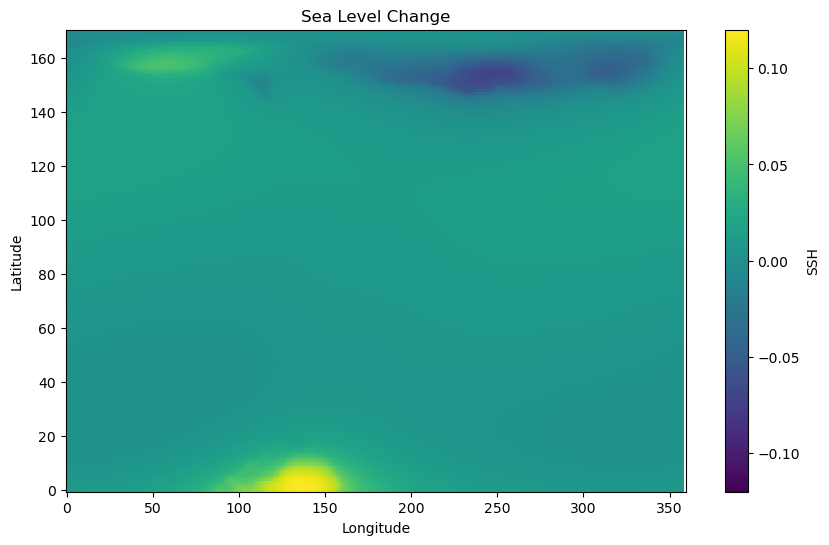

In [4]:
# Select timestep/simualtion number
fingerprint_data_slice = fingerprints['SSH'].isel(time=1, nsim=1)

plt.figure(figsize=(10, 6))
fingerprint_data_slice.plot(cmap='viridis')
plt.title('Sea Level Change')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
# synthetic ocean dynamics dataset
ocean_dynamics = xr.open_dataset(ocean_dynmaics_file)

#### Visualize Synthetic Ocean Dynamics Field

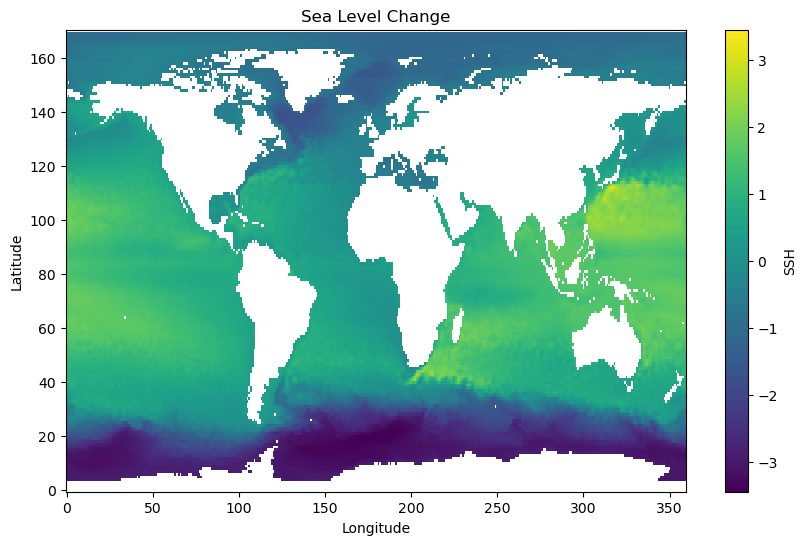

In [6]:
# Select timestep/simualtion number
surrogate_data_slice = ocean_dynamics['SSH'].isel(time=0, nsim=0)

plt.figure(figsize=(10, 6))
surrogate_data_slice.plot(cmap='viridis')
plt.title('Sea Level Change')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [7]:
print(ocean_dynamics['time'])
print('-'*80)
print(fingerprints['time'])

<xarray.DataArray 'time' (time: 336)>
array([1993.    , 1993.0834, 1993.1666, ..., 2020.75  , 2020.8334, 2020.9166],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.993e+03 1.993e+03 ... 2.021e+03 2.021e+03
--------------------------------------------------------------------------------
<xarray.DataArray 'time' (time: 336)>
array([9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36, 9.96921e+36,
       9.96921e+36], dtype=float32)
Coordinates:
  * time     (time) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36


In [8]:
# time columns scaled differently
ocean_dynamics['time'] = fingerprints['time']

In [9]:
synthetics = fingerprints.copy()
synthetics['SSH'] = fingerprints['SSH'] + ocean_dynamics['SSH']

#### Visualize Full Synthetic Field

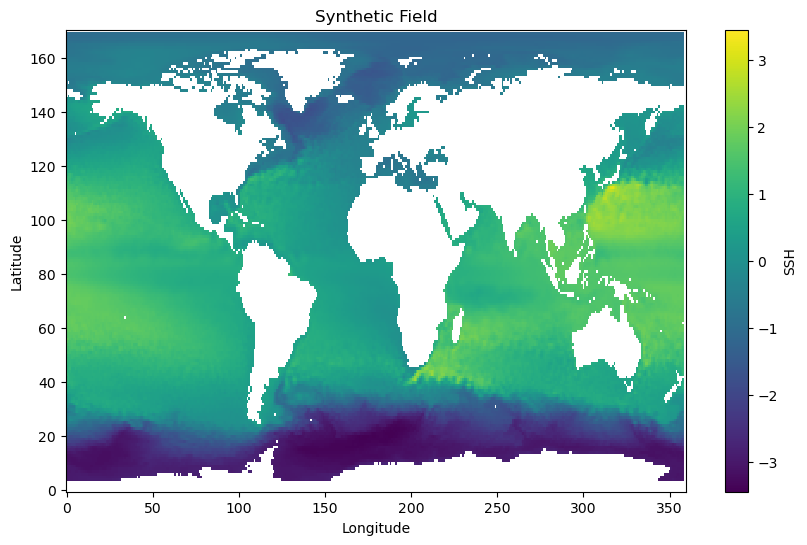

In [10]:
combined_ssh_slice = synthetics['SSH'].isel(time=0, nsim=0)
plt.figure(figsize=(10, 6))
combined_ssh_slice.plot(cmap='viridis')
plt.title('Synthetic Field')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Generate batches of data for training. Input_gen full ocean dynamics combined with fingerprints and target_gen contains only fingerprint (our model's prediction targets)

In [11]:
# Define the starting indices for latitude and longitude for your 5x5 patch
lat_start = 30
lon_start = 175

# Select the 5x5-degree patch from both datasets (synthetics and fingerprints)
input_patch = synthetics.isel(lat=slice(lat_start, lat_start + 5), lon=slice(lon_start, lon_start + 5))
target_patch = fingerprints.isel(lat=slice(lat_start, lat_start + 5), lon=slice(lon_start, lon_start + 5))

In [12]:
# Collapse 'time' and 'nsim' into a single 'sim' dimension for input and target patches
input_patch_collapsed = input_patch.stack(sim=('time', 'nsim'))
target_patch_collapsed = target_patch.stack(sim=('time', 'nsim'))

# Check the new dimensions
print(input_patch_collapsed.dims)
print(target_patch_collapsed.dims)

Frozen({'lat': 5, 'lon': 5, 'sim': 40320})
Frozen({'lat': 5, 'lon': 5, 'sim': 40320})


#### Train/Validation splits

In [13]:
# Define the split index for train/validation based on the new 'sim' dimension
split_idx = int(0.8 * input_patch_collapsed.sizes['sim'])

# Training set (80% of the 'sim' dimension)
input_train = input_patch_collapsed.isel(sim=slice(0, split_idx))
target_train = target_patch_collapsed.isel(sim=slice(0, split_idx))

# Validation set (remaining 20% of the 'sim' dimension)
input_val = input_patch_collapsed.isel(sim=slice(split_idx, None))
target_val = target_patch_collapsed.isel(sim=slice(split_idx, None))


#### Create Batch Generators

In [14]:
# BatchGenerators for the training set (collapsed data)
train_input_gen = xbatcher.BatchGenerator(input_train, {'sim': split_idx, 'lat': 5, 'lon': 5})
train_target_gen = xbatcher.BatchGenerator(target_train, {'sim': split_idx, 'lat': 5, 'lon': 5})

# BatchGenerators for the validation set (collapsed data)
val_input_gen = xbatcher.BatchGenerator(input_val, {'sim': input_val.sizes['sim'], 'lat': 5, 'lon': 5})
val_target_gen = xbatcher.BatchGenerator(target_val, {'sim': input_val.sizes['sim'], 'lat': 5, 'lon': 5})


In [15]:
# Example of iterating through training batches
for input_batch, target_batch in zip(train_input_gen, train_target_gen):
    # Use input_batch and target_batch to train your CNN
    print("Input batch shape:", input_batch['SSH'].shape)
    print("Target batch shape:", target_batch['SSH'].shape)
    print("Input patch dimensions ['SSH']:", input_patch['SSH'].dims)
    print("Target patch dimensions ['SSH']:", target_patch['SSH'].dims)
    print("Input patch dimensions:", input_patch.dims)
    print("Target patch dimensions:", target_patch.dims)

Input batch shape: (5, 5, 32256)
Target batch shape: (5, 5, 32256)
Input patch dimensions ['SSH']: ('time', 'lat', 'lon', 'nsim')
Target patch dimensions ['SSH']: ('time', 'lat', 'lon', 'nsim')
Input patch dimensions: Frozen({'lat': 5, 'lon': 5, 'time': 336, 'nsim': 120})
Target patch dimensions: Frozen({'lat': 5, 'lon': 5, 'time': 336, 'nsim': 120})


In [16]:
# Function to visualize input, prediction, and target for multiple samples
def visualize_examples(inputs, predictions, targets, num_examples=5):
    """
    Visualizes input, prediction, and target for multiple samples.
    
    Parameters:
    - inputs: Input tensor (batch_size, 1, 5, 5)
    - predictions: Model predictions (batch_size, 25)
    - targets: Target tensor (batch_size, 25)
    - num_examples: Number of examples to visualize
    """
    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
        target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

In [17]:
def z_score_normalize(data):
  return (data - torch.mean(data)) / torch.std(data)

#### In order to generate signal filter without having knowledge of the target patch's magnitude spectrum, we should try building a neural network to estimate the input patch's 'optimal' magnitude such that it minimizes the difference between target patch and input patch (post-filter).

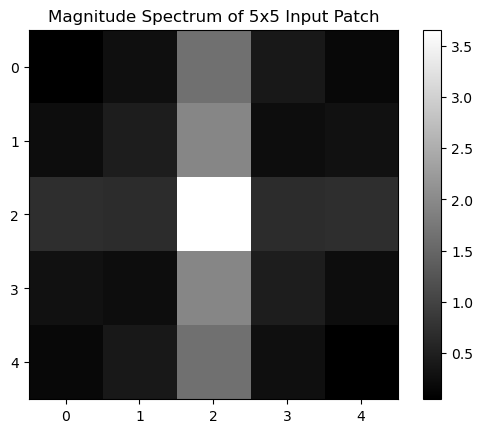

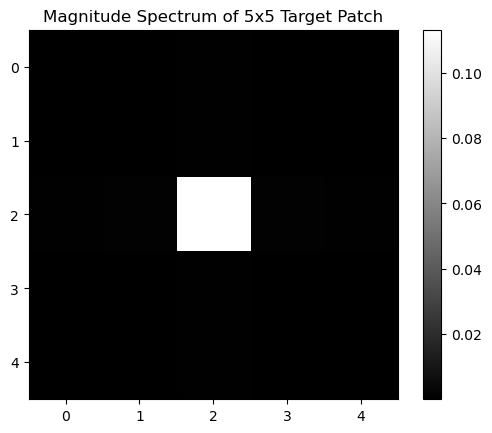

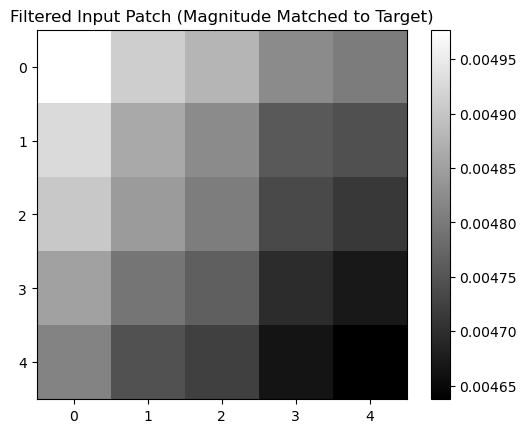

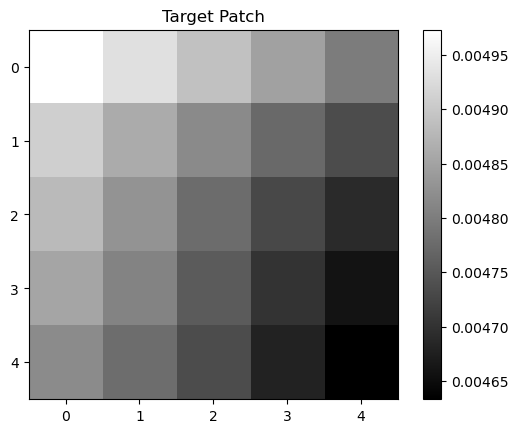

In [22]:
for input_batch, target_batch in zip(train_input_gen, train_target_gen):
    # Convert input batch to tensor and prepare input patch
    inputs = torch.tensor(input_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1)
    input_patch = inputs[1].detach().numpy()
    
    # Convert target batch to tensor and prepare target patch
    targets = torch.tensor(target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1)
    target_patch = targets[1].detach().numpy()
    
    # Perform FFT on input and target patches
    fft_input_patch = np.fft.fft2(input_patch)
    fft_target_patch = np.fft.fft2(target_patch)
    
    # Shift the zero-frequency component to the center for visualization
    fft_input_shifted = np.fft.fftshift(fft_input_patch)
    fft_target_shifted = np.fft.fftshift(fft_target_patch)
    
    # Compute the magnitude and phase of input and target patches
    input_magnitude_spectrum = np.abs(fft_input_shifted)
    input_phase_spectrum = np.angle(fft_input_shifted)
    target_magnitude_spectrum = np.abs(fft_target_shifted)
    
    # Plot the input magnitude spectrum
    plt.imshow(np.log(1 + input_magnitude_spectrum), cmap='gray')
    plt.title('Magnitude Spectrum of 5x5 Input Patch')
    plt.colorbar()
    plt.show()
    
    # Plot the target magnitude spectrum
    plt.imshow(np.log(1 + target_magnitude_spectrum), cmap='gray')
    plt.title('Magnitude Spectrum of 5x5 Target Patch')
    plt.colorbar()
    plt.show()
    
    # Replace the magnitude of the input patch with the target patch's magnitude; OUR NNET WOULD BE PREDICTING TARGET_MAGNITUDE_SPECTRUM
    fft_filtered_input_shifted = target_magnitude_spectrum * np.exp(1j * input_phase_spectrum)
    
    # Shift back to the original FFT layout
    fft_filtered_input = np.fft.ifftshift(fft_filtered_input_shifted)
    
    # Perform the inverse FFT to get the filtered input in the spatial domain
    filtered_input = np.fft.ifft2(fft_filtered_input)
    
    # Get the real part of the filtered input
    filtered_input_real = np.real(filtered_input)
    
    # Visualize the filtered input patch
    plt.imshow(-1*filtered_input_real, cmap='gray')
    plt.title('Filtered Input Patch (Magnitude Matched to Target)')
    plt.colorbar()
    plt.show()

    # Visualize the target input patch
    plt.imshow(target_patch, cmap='gray')
    plt.title('Target Patch')
    plt.colorbar()
    plt.show()
    
    break

In [19]:
# from re import X
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm
# import numpy as np
# import matplotlib.pyplot as plt

# class ConvolutionalBlock(nn.Module):
#   def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
#     super(ConvolutionalBlock, self).__init__()
#     # may be beneficial to look at this like a 1d sequence since it is a regression task?
#     self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
#     self.bnorm = nn.BatchNorm2d(out_channels)
#     self.relu = nn.ReLU()

#   def forward(self, x):
#     #Following resnet conv block
#     # self.out = self.pool(self.dropout(self.relu(self.bnorm(self.conv(x)))))
#     self.out = self.relu(self.bnorm(self.conv(x)))
#     return self.out

# class SimpleCNN(nn.Module):
#   def __init__(self, num_layers=2):
#     super(SimpleCNN, self).__init__()
#     self.num_layers = num_layers

#     self.conv1 = ConvolutionalBlock(1, 32)
#     self.conv2 = ConvolutionalBlock(32, 64)
#     self.conv3 = ConvolutionalBlock(64, 128)
#     self.dropout = nn.Dropout(0.2)

#     self.fc1 = nn.Linear(128, 64)
#     # self.fc2 = nn.Linear(256, 512)
#     # self.fc3 = nn.Linear(512, 256)
#     self.fc4 = nn.Linear(64, 64)
#     self.fc5 = nn.Linear(64, 5*5)

#     self.relu = nn.ReLU()
#     self.pool = nn.MaxPool2d(2, 2)

#     self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))


#   def forward(self, x):
#     # Input shape is currently 5x5 or 1x5x5
#     # x = torch.flatten(x, 0, 1)
#     x = self.conv1(x)
#     x = self.pool(self.conv2(x))
#     x = self.conv3(x)
#     x = self.global_avg_pool(x)
#     x = x.view(x.size(0), -1)
#     x = self.relu(self.fc1(x))
#     # x = self.relu(self.fc2(x))
#     # x = self.relu(self.fc3(x))
#     x = self.dropout(x)
#     x = self.relu(self.fc4(x))
#     x = self.fc5(x)
#     x = x.view(32256, 25)
#     return x

In [20]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt

# # Define the enhanced CNN model with pooling layer and global average pooling
# class EnhancedFingerprintCNN(nn.Module):
#     def __init__(self):
#         super(EnhancedFingerprintCNN, self).__init__()
#         # First set of convolutional layers
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
        
#         # Second set of convolutional layers
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
        
#         # Max pooling layer
#         self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window
        
#         # Global average pooling (replaces the second pooling layer)
#         self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(128, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 25)
        
#         # Dropout layer for regularization
#         self.dropout = nn.Dropout(0.1)
    
#     def _forward_conv_layers(self, x):
#         # First set of convolutions + batch norm + pooling
#         x = self.bn1(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
#         # Second set of convolutions + batch norm
#         x = self.bn3(torch.relu(self.conv3(x)))
        
#         # Apply global average pooling instead of max pooling
#         x = self.global_avg_pool(x)
        
#         return x
    
#     def forward(self, x):
#         # Forward pass through conv layers
#         x = self._forward_conv_layers(x)
        
#         # Flatten the output
#         x = x.view(x.size(0), -1)
        
#         # Fully connected layers with dropout and ReLU
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)  # Apply dropout after first FC layer
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)  # Output layer
        
#         return x

# # Visualization function
# def visualize_examples(inputs, predictions, targets, num_examples=5):
#     """
#     Visualizes input, prediction, and target for multiple samples.
    
#     Parameters:
#     - inputs: Input tensor (batch_size, 1, 5, 5)
#     - predictions: Model predictions (batch_size, 25)
#     - targets: Target tensor (batch_size, 25)
#     - num_examples: Number of examples to visualize
#     """
#     for i in range(num_examples):
#         input_sample = inputs[i].squeeze().numpy()  # (5, 5)
#         prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
#         target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

#         # Plot input, prediction, and target side by side
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#         # Input visualization
#         axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
#         axes[0].set_title(f"Input {i + 1}")
#         axes[0].axis('off')

#         # Prediction visualization
#         axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
#         axes[1].set_title(f"Prediction {i + 1}")
#         axes[1].axis('off')

#         # Target visualization
#         axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
#         axes[2].set_title(f"Target {i + 1}")
#         axes[2].axis('off')

#         plt.show()

# # Instantiate the enhanced model, loss function, optimizer, and scheduler
# model = EnhancedFingerprintCNN()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.003)

# # StepLR scheduler: decay LR by a factor of 0.5 every 10 epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# # Training loop
# epochs = 40
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     for input_batch, target_batch in zip(train_input_gen, train_target_gen):
#         # Reshape the input batch
#         inputs = torch.tensor(input_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1)  # (32256, 1, 5, 5)
#         targets = torch.tensor(target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).view(-1, 25)  # (32256, 25)

#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         predictions = model(inputs)
        
#         # Compute loss
#         loss = criterion(predictions, targets)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Track running loss
#         running_loss += loss.item()

#     # Step the scheduler after every epoch
#     scheduler.step()

#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_input_gen)}, Learning Rate: {scheduler.get_last_lr()[0]}")

# # Visualize 5 examples after the final epoch
# with torch.no_grad():
#     visualize_examples(inputs, predictions, targets, num_examples=5)
